# Intro

In this notebook we will explore the geo entities of the dataset 

In [1]:
import pandas as pd
import numpy as np
import ast 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import re

/Users/alextabora/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [23]:
articles = pd.read_csv("../files/criminal_articles.csv")
#remove articles without content
articles = articles[articles["content"] != "[[]]" ]
# cast string into array
articles.loc[:,"title"] = articles.title.apply(lambda x: ast.literal_eval(x) )
articles.loc[:,"content"] = articles.content.apply(lambda x: ast.literal_eval(x) )



combined  = []
for _, article in articles.iterrows():
    combined.append([article.title] + article.content)
    
articles.loc[:,"combined"] = combined

In [24]:
print articles.shape
articles.head()

(292, 5)


,article_id,title,content,relationships,combined
0,3,"[[Citan, none], [a, none], [11, none], [person...","[[[SAN, B-City], [PEDRO, I-City], [SULA, I-Cit...","[[{u'tag': u'B-Col', u'word': u'lomas del carm...","[[[Citan, none], [a, none], [11, none], [perso..."
1,5,"[[DEI, none], [pide, none], [denunciar, none],...","[[[TEGUCIGALPA, B-City]], [[-, none], [Autorid...",[],"[[[DEI, none], [pide, none], [denunciar, none]..."
2,9,"[[Alcaldía, none], [intensifica, none], [opera...","[[[TEGUCIGALPA, B-City]], [[-, none], [Pese, n...","[[{u'tag': u'B-Col', u'word': u'kennedy'}, {u'...","[[[Alcaldía, none], [intensifica, none], [oper..."
3,11,"[[Pasajeros, none], [asaltantes, none], [acrib...","[[[PUERTO, B-City], [CORTES, I-City], [,, none...","[[{u'tag': u'B-City', u'word': u'puerto cortes...","[[[Pasajeros, none], [asaltantes, none], [acri..."
4,12,"[[Fallece, none], [comerciante, none], [olanch...","[[[JUTICALPA, B-City], [,, none], [Olancho, B-...","[[{u'tag': u'B-City', u'word': u'juticalpa'}, ...","[[[Fallece, none], [comerciante, none], [olanc..."


# 1. Preprocess

Convert the format into an article-sentence-word format (one row per word)

In [25]:
def convert_to_words(df):
    data = []
    cs_id = -1  #corpus sentence id
    last_id = -1
    last = "none"
    for _, article in df.iterrows():
        for sent_ix, sentence in enumerate(article.combined):
            cs_id += 1
            for pos, word in enumerate(sentence):
                if word[1] == "none":
                    ent_id = None
                elif word[1][0] == "B":
                    last_id += 1
                    ent_id = last_id
                else:
                    ent_id = last_id
                data.append([article.article_id, sent_ix, word[0], word[1], cs_id, ent_id,pos])
                
    words_df = pd.DataFrame(data, columns=["art_id", "sent_id", "word", "tag","cs_id", "ent_id", "pos"])
    
    #if it is entity
    words_df.loc[:,"entity"] = words_df.tag.apply(lambda x: int(x[0] == "B"))
    #if it is part of entity
    words_df.loc[:,"part"] = words_df.tag.apply(lambda x: int(x != "none"))
    return words_df
                
words_df = convert_to_words(articles)    
words_df.head()

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part
0,3,0,Citan,none,0,NaN,0,0,0
1,3,0,a,none,0,NaN,1,0,0
2,3,0,11,none,0,NaN,2,0,0
3,3,0,personas,none,0,NaN,3,0,0
4,3,0,por,none,0,NaN,4,0,0


# 2. Analysis

## 2.1 How many 

In [26]:
# number of articles
num_articles = words_df.art_id.unique().shape[0]
num_sentences = words_df[["art_id","sent_id"]].groupby(by="art_id").max().values.sum()
num_entities = words_df[words_df["tag"].apply(lambda x: x[0] == "B")].shape[0]
num_words = words_df.shape[0]


# sentences per article
print "Avg. sentences per article: %0.4f"  %(num_sentences * 1.0 /  num_articles)

# words per article
print "Avg. words per article: %0.4f"  % (num_words * 1.0  / num_articles)

# entities per article
print "Avg. entities per article: %0.4f"  % (num_entities * 1.0 / num_articles )


print 


# words per sentence
print "Avg. words per sentence: %0.4f"  % (num_words * 1.0 / num_sentences )

# entities per sentence
print "Avg. entities per sentence: %0.4f"  % (num_entities * 1.0 / num_sentences )



# ratio of entities and words
print "Ratio of entities/words: %0.4f"  % (num_entities * 1.0 / num_words )
print "Ratio of words/entities: %0.4f"  % (num_words * 1.0 / num_entities )



Avg. sentences per article: 9.6815
Avg. words per article: 298.7568
Avg. entities per article: 5.8973

Avg. words per sentence: 30.8585
Avg. entities per sentence: 0.6091
Ratio of entities/words: 0.0197
Ratio of words/entities: 50.6603


In [27]:
print num_articles
print num_sentences
print num_words
print num_entities

print words_df.ent_id.max()

292
2827
87237
1722
1721.0


## 2.2 ARTICLES

In [28]:
articles_df = pd.DataFrame({
    "art_id": words_df.art_id.unique(),
    "sentences": words_df.groupby(by="art_id")["sent_id"].max().values,
    "words": words_df.groupby(by="art_id")["word"].count().values,
    "entities":words_df.groupby(by="art_id")["entity"].sum().values,
    "parts":words_df.groupby(by="art_id")["part"].sum().values,
})

articles_df[["entities", "parts","sentences", "words"]].describe()

,entities,parts,sentences,words
count,292.000000,292.000000,292.000000,292.000000
mean,5.897260,9.291096,9.681507,298.756849
std,4.498537,7.292197,6.262686,215.300763
min,0.000000,0.000000,3.000000,68.000000
25%,3.000000,5.000000,6.000000,166.750000
50%,5.000000,8.000000,8.000000,245.500000
75%,7.000000,12.000000,11.000000,351.250000
max,47.000000,61.000000,46.000000,1702.000000


## 2.3 Sentences

In [29]:
sentences_df = pd.DataFrame({
    "words": words_df.groupby(by="cs_id")["word"].count().values,
    "entities":words_df.groupby(by="cs_id")["entity"].sum().values,
    "parts":words_df.groupby(by="cs_id")["part"].sum().values,
})

sentences_df.describe()

,entities,parts,words
count,3114.000000,3114.000000,3114.000000
mean,0.552987,0.871227,28.014451
std,1.000443,1.790269,15.579278
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,17.000000
50%,0.000000,0.000000,27.000000
75%,1.000000,1.000000,38.000000
max,10.000000,21.000000,193.000000


## 2.3 Entities

In [30]:
entities_df = pd.DataFrame({
    "parts":words_df.dropna(axis=0).groupby(by="ent_id")["part"].sum().values,
})
entities_df.describe()

,parts
count,1722.000000
mean,1.575494
std,0.871355
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7.000000


## 2.4 By Position

### 2.4.1 Entities - Sentences

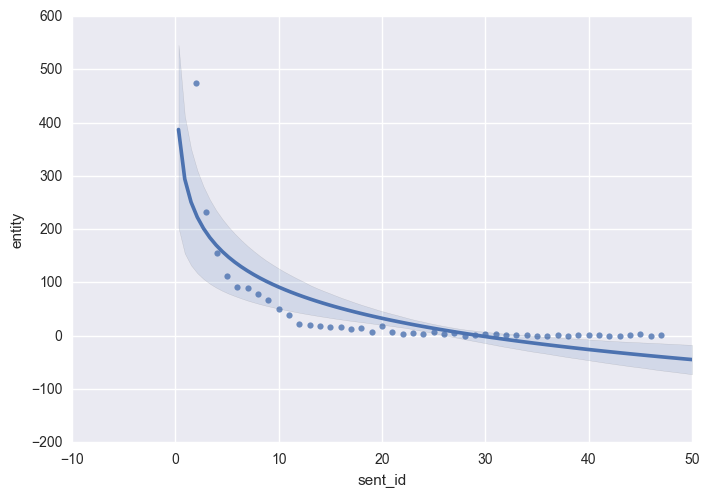

In [83]:
# IMPORTANT this is depending on SENTENCE POSITION!!!!! ---> Word positions also matter!!!
data = words_df[words_df["sent_id"]>0].groupby(by=["sent_id"])["entity"].sum().reset_index(0)
data.sent_id = data.sent_id.apply(lambda x: x+1)

sns.regplot(x="sent_id",y="entity", data= data ,
             logx=True,  lowess=False, order=1, scatter=True, fit_reg=True,truncate=False, robust=False,
           )
plt.show()

### 2.4.2 Word position in a sentence

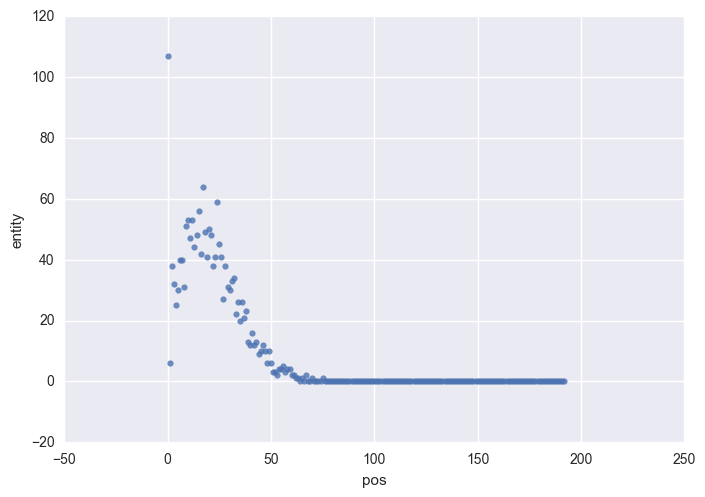

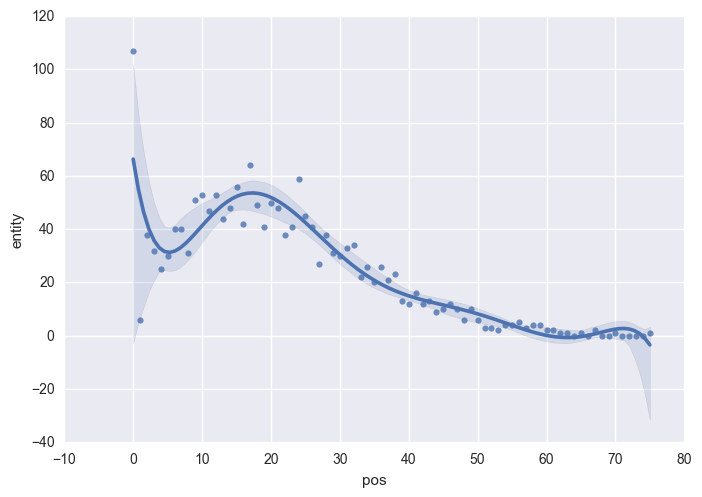

In [32]:
sns.regplot(x="pos",y="entity", data= words_df.groupby(by=["pos"])["entity"].sum().reset_index(0),
            fit_reg=False,truncate=True,
           )
plt.show()
sns.regplot(x="pos",y="entity", data= words_df[words_df["pos"]<=75].groupby(by=["pos"])["entity"].sum().reset_index(0),
            fit_reg=True,truncate=True,order=7,
           )
plt.show()

### 2.4.3 

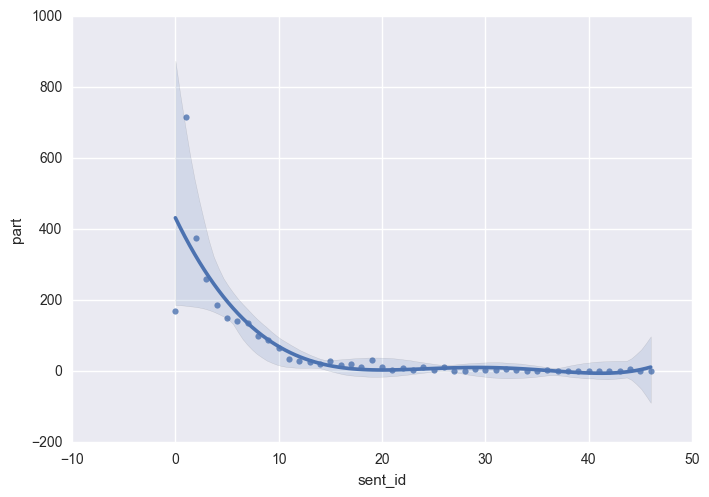

In [33]:
# IMPORTANT this is depending on SENTENCE POSITION!!!!! ---> Word positions also matter!!!
sns.regplot(x="sent_id",y="part", data= words_df.groupby(by=["sent_id"])["part"].sum().reset_index(0) ,
           truncate=True, order=5 )
plt.show()

### 2.4.4

75


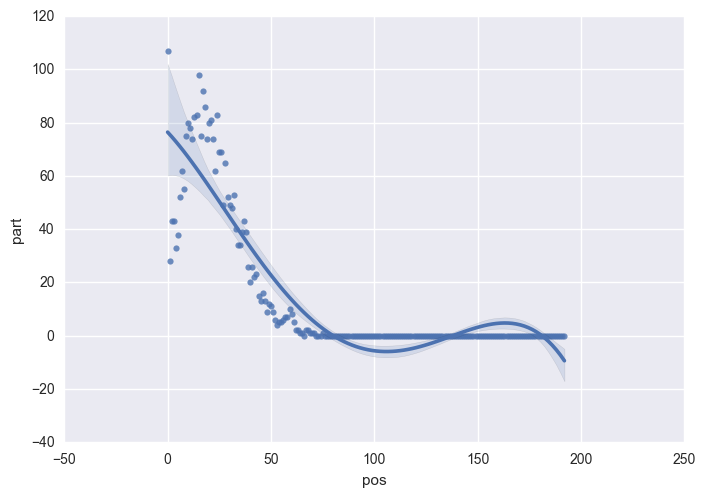

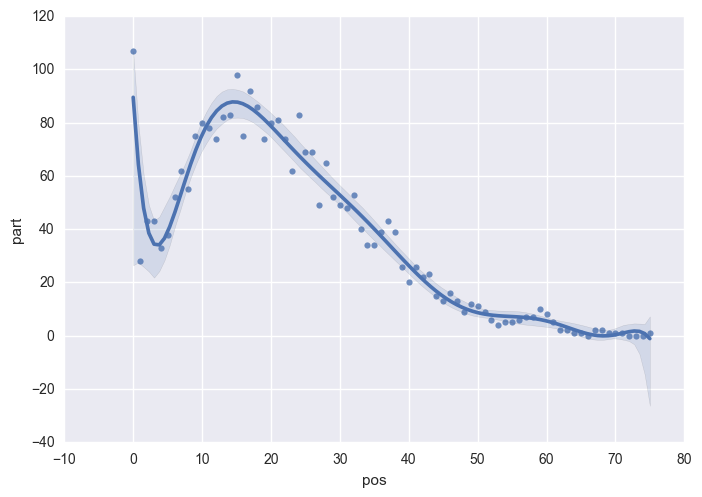

In [34]:
# IMPORTANT this is depending on SENTENCE POSITION!!!!! ---> Word positions also matter!!!
pos_df = words_df.groupby(by=["pos"])["part"].sum().reset_index(0)
print pos_df[pos_df["part"]>0].pos.max()
sns.regplot(x="pos",y="part", data= pos_df,truncate=True, order=4 )
plt.show()
sns.regplot(x="pos",y="part", data= pos_df[pos_df["pos"]<=75], order=9, truncate=True )
plt.show()


## 2.5 View Frequencies

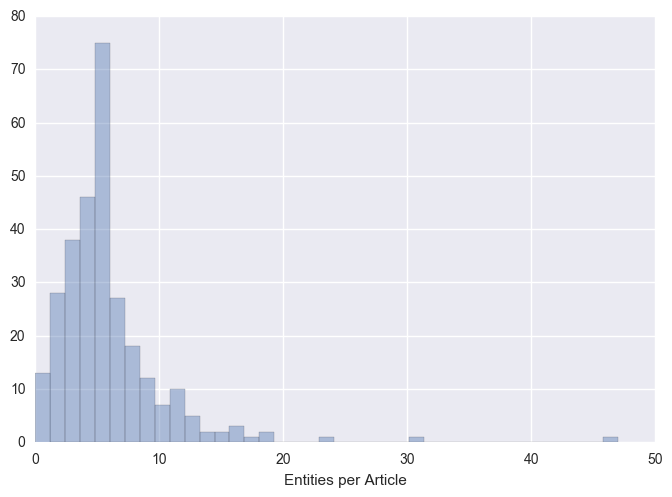

In [35]:

sns.distplot( words_df.groupby(by=["art_id"])["entity"].sum(), 
             color = 'b', kde=False, hist=True, 
             axlabel="Entities per Article"  )
plt.show()

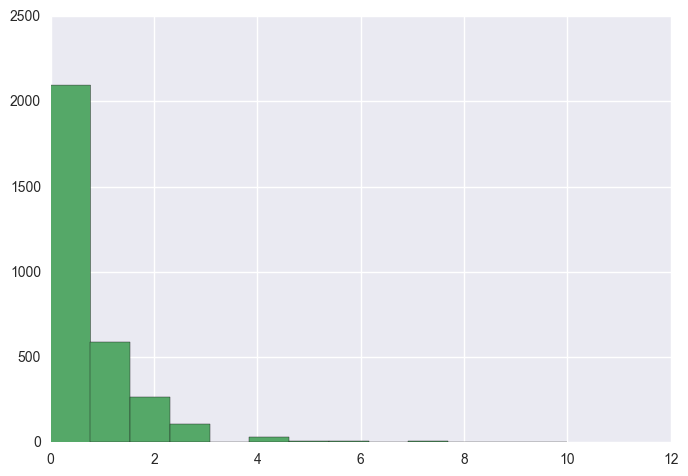

In [36]:
words_df.groupby(by=["cs_id"])["entity"].sum().hist(bins=13, color='g')
plt.show()

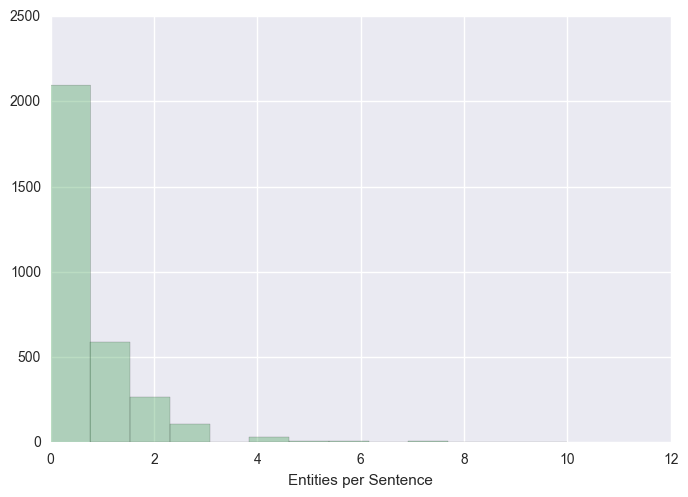

In [37]:
sns.distplot( words_df.groupby(by=["cs_id"])["entity"].sum(),
             color = 'g', kde=False, hist=True, bins= 13,
             axlabel="Entities per Sentence"  )
plt.show()

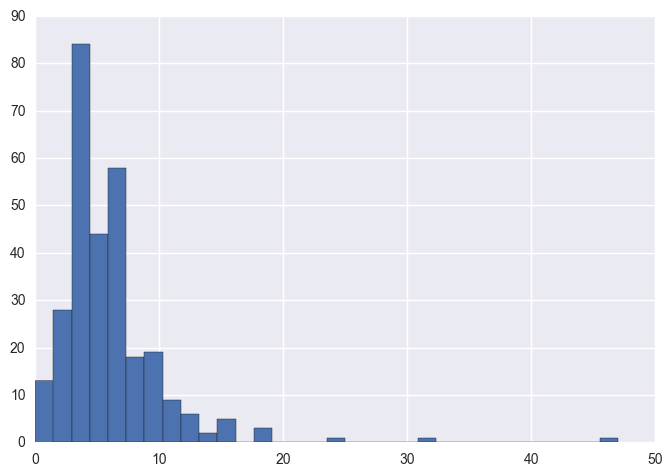

In [38]:
words_df.groupby(by=["art_id"])["entity"].sum().hist(bins=32)
plt.show()

## 2.6 Common words of the sentences

In [39]:
import nltk
# from nltk import wordpunct_tokenize, RegexpTokenizer
from wordcloud import WordCloud
stop_words = pd.read_json("../files/stopwords.json")[0].values.tolist()

In [40]:
def show_wordcloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(background_color="white",
                          max_font_size=40, relative_scaling=.9).generate(text )

    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### 2.6.1 sentences with entities

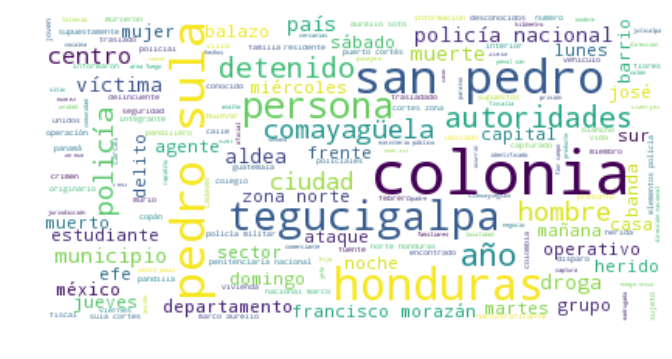

In [41]:
# cs_id of all the sentences with entities
entity_sents = words_df[words_df["entity"]==1].cs_id.unique()

# words of the sentences with entities 
tokens_es = words_df[words_df["cs_id"].isin(entity_sents)].word.apply(lambda text: text.lower())

#distribution of most common words
tokens_es = [ token for token in tokens_es if token not in stop_words]
fdist = nltk.FreqDist(tokens_es)
# for w in  fdist.most_common(30):
#     print "%s , %i" %(w[0], w[1])
show_wordcloud(tokens_es)

### 2.6.2 sentences without entities

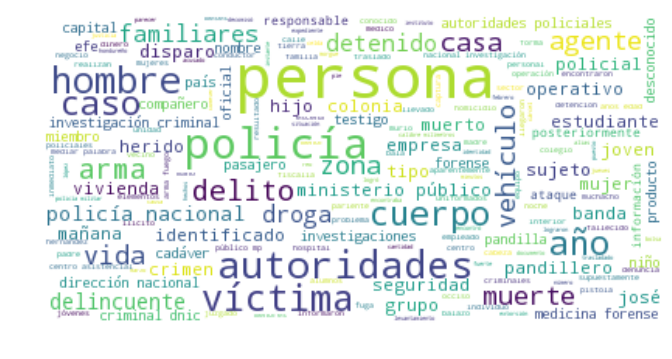

In [42]:
# words of the sentences without entities 
tokens_we = words_df[ np.logical_not(words_df["cs_id"].isin(entity_sents)) ].word.apply(lambda text: text.lower())

#distribution of most common words
tokens_we = [ token for token in tokens_we if token not in stop_words]
fdist = nltk.FreqDist(tokens_we)
# for w in  fdist.most_common(30):
#     print "%s , %i" %(w[0], w[1])
show_wordcloud(tokens_we)

### 2.6.3 Words in Common, Words not in common

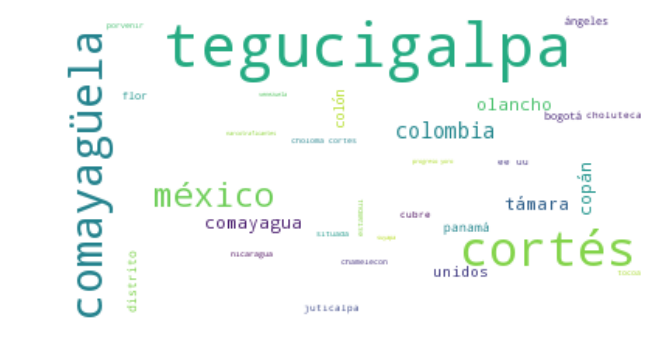

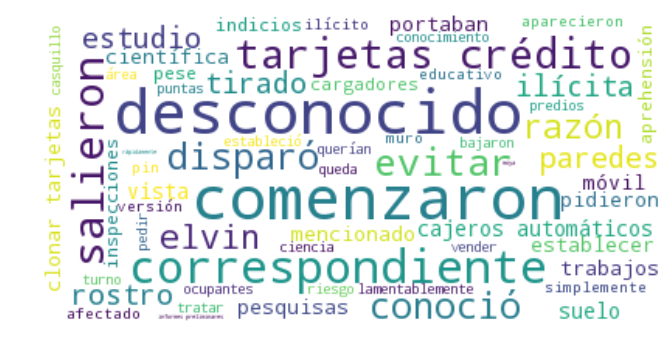

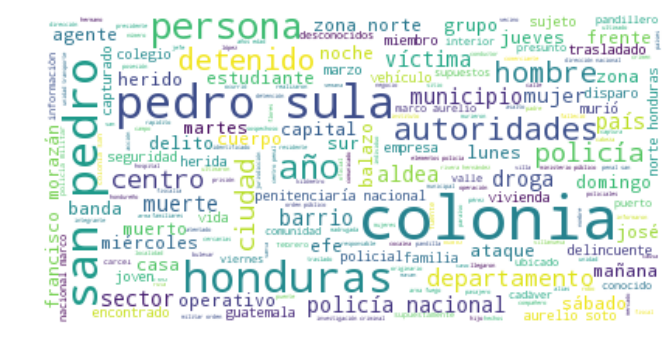

In [43]:
# just try and see which words are in common ... which ones are unique for them
set_we = set(tokens_we)
set_es = set(tokens_es)

unique_es = set_es - set_we
unique_we = set_we - set_es
common = set_es & set_we


show_wordcloud([w for w in tokens_es if w in unique_es])
show_wordcloud([w for w in tokens_we if w in unique_we])

show_wordcloud([w for w in (tokens_es) if w in common])



### Conclusion
They share almost all of the same words but not at with the same distributions... they share even names since some institutions, projects and operations use or have a name that could be a city, a state or a country.

# 2.7 size of sentence vs  entities
### 2.7.1 size of sentence vs number of entities

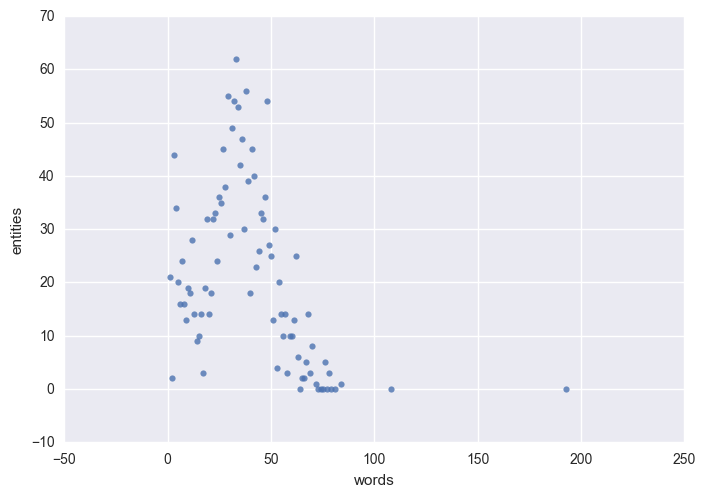

In [44]:

sns.regplot(x="words",y="entities", data= sentences_df[sentences_df["words"]<1000] \
            .groupby(by=["words"])["entities"].sum().reset_index(0), order=1, truncate=True,
           fit_reg=False,)



# sns.jointplot( data=sentences_df[sentences_df["words"]<1000].groupby(by=["words"])["entities"].sum().reset_index(0),
#              x="words", y="entities",)

plt.show()
# sentences_df

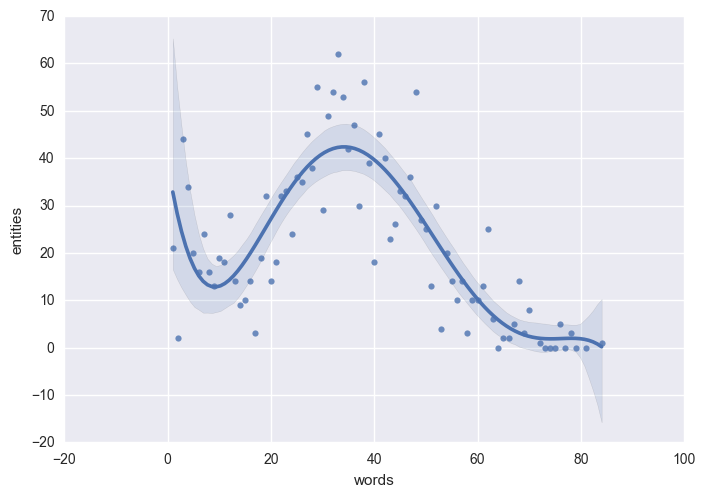

In [45]:

sns.regplot(x="words",y="entities", data= sentences_df[sentences_df["words"]<100] \
            .groupby(by=["words"])["entities"].sum().reset_index(0), order=5, truncate=True )
plt.show()
# sentences_df

### 2.7.2 size of sentence vs entity (i.e probability of given a size then entity)

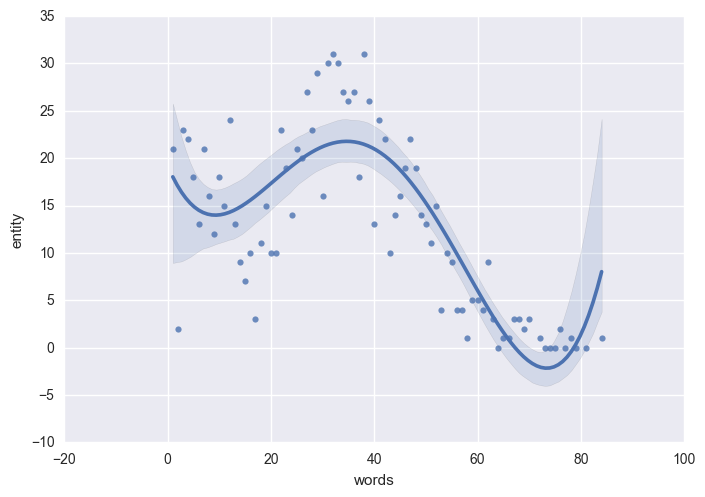

In [46]:
sentences_df.loc[:,"entity"] = sentences_df.entities.apply(lambda x: int(x>0))


sns.regplot(x="words",y="entity", data= sentences_df[sentences_df["words"]<100]\
            .groupby(by="words").entity.sum().reset_index(0) ,
             order=4, truncate=True )
plt.show()

In [47]:
words_df.head()

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part
0,3,0,Citan,none,0,NaN,0,0,0
1,3,0,a,none,0,NaN,1,0,0
2,3,0,11,none,0,NaN,2,0,0
3,3,0,personas,none,0,NaN,3,0,0
4,3,0,por,none,0,NaN,4,0,0


In [48]:
data = []

prev_1 = None
prev_2 = None
prev_3 = None
for ix, row in words_df.iterrows():
    if row.pos == 0:
        prev_1 = None
        prev_2 = None
        prev_3 = None
    
    if row.tag[0] == "B":
        data.append([row.art_id, row.sent_id, row.pos, row.word, row.tag, prev_1, prev_2, prev_3])
    #uncomment this to debug
#     else:
#         data.append([row.art_id, row.sent_id, row.pos, row.word, row.tag, prev_1, prev_2, prev_3])
        
    prev_3 = prev_2
    prev_2 = prev_1
    prev_1 = row.word
    
prevs_df = pd.DataFrame(data,columns=["art_id", "sent_id", "pos", "word", "tag", "prev_1", "prev_2","prev_3"])
    
prevs_df.head(20)    
        

,art_id,sent_id,pos,word,tag,prev_1,prev_2,prev_3
0,3,1,0,SAN,B-City,None,None,None
1,3,2,26,San,B-City,de,Municipal,Policía
2,3,3,13,San,B-City,de,puntos,distintos
3,3,4,38,Lomas,B-Col,“,colonia,la
4,3,6,19,Monumento,B-Zone,“,",",bulevares
5,3,6,24,primera,B-Zone,"”,",Madre,la
6,3,6,27,parque,B-Zone,y,avenida,primera
7,3,8,11,San,B-City,en,quemados,niños
8,5,1,0,TEGUCIGALPA,B-City,None,None,None
9,9,1,0,TEGUCIGALPA,B-City,None,None,None


In [49]:
fdist_1 = nltk.FreqDist(prevs_df.prev_1.apply(lambda x: x.lower() if x != None else x ))
print "Vocabulary size: %i" %len(fdist_1)
print 
for w in  fdist_1.most_common(10):
    print "%s , %i" %(w[0], w[1])

Vocabulary size: 68

de , 586
en , 272
, , 227
colonia , 146
None , 107
la , 50
y , 43
barrio , 30
aldea , 27
del , 19


In [50]:
fdist_2 = nltk.FreqDist(prevs_df.prev_2.apply(lambda x: x.lower() if x != None else x ))
print "Vocabulary size: %i" %len(fdist_2)
print 
for w in  fdist_2.most_common(10):
    print "%s , %i" %(w[0], w[1])

Vocabulary size: 620

la , 189
None , 113
, , 39
municipio , 36
en , 33
el , 32
departamento , 30
norte , 27
de , 24
del , 20


In [51]:
fdist_3 = nltk.FreqDist(prevs_df.prev_3.apply(lambda x: x.lower() if x != None else x ))
print "Vocabulary size: %i" %len(fdist_3)
print 
for w in  fdist_3.most_common(10):
    print "%s , %i" %(w[0], w[1])

Vocabulary size: 385

de , 199
en , 170
None , 151
el , 108
la , 106
, , 79
del , 62
zona , 34
las , 28
colonia , 20


In [52]:
# the three combined
tokens_1 = prevs_df.prev_1.apply(lambda x: x.lower() if x != None else x ).values.tolist()
tokens_2 = prevs_df.prev_2.apply(lambda x: x.lower() if x != None else x ).values.tolist()
tokens_3 = prevs_df.prev_3.apply(lambda x: x.lower() if x != None else x ).values.tolist()

fdist = nltk.FreqDist(tokens_1+tokens_2+tokens_3)
print "Vocabulary size: %i" %len(fdist)
print 
for w in  fdist.most_common(100):
    print "%s , %i" %(w[0], w[1])


Vocabulary size: 891

de , 809
en , 475
None , 371
la , 345
, , 345
colonia , 169
el , 158
del , 101
y , 74
aldea , 45
a , 45
zona , 41
municipio , 36
departamento , 35
barrio , 35
las , 32
norte , 27
centro , 25
que , 23
los , 22
un , 20
capital , 20
- , 20
como , 20
ciudad , 19
estado , 19
sula , 18
( , 18
con , 18
al , 18
pedro , 17
ruta , 17
penal , 17
“ , 16
una , 16
policía , 16
hacia , 14
tegucigalpa , 14
sector , 14
originario , 14
nacional , 14
colonias , 14
comunidad , 13
), , 13
bulevar , 13
san , 11
hoy , 10
por , 10
) , 10
distrito , 10
soto , 10
central , 10
mercado , 10
sur , 9
cubre , 9
autoridades , 9
campo , 9
cárcel , 9
comayagüela , 9
choloma , 8
desde , 8
honduras , 8
” , 8
aeropuerto , 8
conocido , 8
aduana , 8
danlí , 8
nueva , 8
hospital , 7
su , 7
se , 7
puerto , 7
oriental , 7
localidad , 7
támara , 7
paraíso , 7
francisco , 7
tiloarque , 6
comercial , 6
villanueva , 6
copán , 6
este , 6
cortés , 6
cerca , 6
progreso , 6
cofradía , 6
procedente , 6
residencial

In [53]:
spaces_dummy = pd.Series([" " for i in range(prevs_df.shape[0])])

# bigram ...
prevs_df.loc[:,"bigram"]= prevs_df.prev_2 + spaces_dummy  + prevs_df.prev_1

fdist_bigram = nltk.FreqDist(prevs_df.bigram.apply(lambda x: x.lower() if type(x) == str else x ))
print "Vocabulary size: %i" %len(fdist_bigram)
print 
for w in  fdist_bigram.most_common(20):
    print "%s , %i" %(w[0], w[1])

Vocabulary size: 799

la colonia , 140
nan , 113
municipio de , 35
norte de , 27
departamento de , 26
la aldea , 25
, en , 25
de la , 18
el barrio , 17
Sula , , 16
aldea de , 15
originario de , 14
en la , 14
ciudad de , 12
la ruta , 11
comunidad de , 11
en el , 11
capital de , 10
Tegucigalpa , , 10
Penal de , 9


In [54]:
# trigram ...
prevs_df.loc[:,"trigram"]= prevs_df.prev_3 + spaces_dummy + prevs_df.prev_2 + spaces_dummy  + prevs_df.prev_1

fdist_trigram = nltk.FreqDist(prevs_df.trigram.apply(lambda x: x.lower() if type(x) == str else x ))
print "Vocabulary size: %i" %len(fdist_trigram)
print 
for w in  fdist_trigram.most_common(40):
    print "%s , %i" %(w[0], w[1])

Vocabulary size: 1009

nan , 151
en la colonia , 80
de la colonia , 46
zona norte de , 18
en el barrio , 17
Pedro Sula , , 16
del municipio de , 15
el departamento de , 14
el municipio de , 13
de la aldea , 13
la ciudad de , 12
la comunidad de , 11
, departamento de , 9
la aldea de , 8
el sector de , 8
en la aldea , 8
cubre la ruta , 7
Centro Penal de , 7
en Tegucigalpa , , 7
la aduana de , 7
de Honduras , , 6
a la colonia , 6
de Comayagüela , , 6
la capital de , 6
del Estado de , 6
Soto , en , 6
la cárcel de , 6
del Campo - , 6
en Támara , , 5
la zona de , 5
el estado de , 5
Medicina Forense de , 5
zona oriental de , 5
el norte de , 5
conocido como “ , 5
centro penal de , 4
la localidad de , 4
Las Torres - , 4
Policía Nacional en , 4
zona central de , 4


## 2.8 Frequency of location types

In [55]:
# All of the tags
words_df.tag.value_counts()

none         84524
B-City         713
I-City         432
B-Country      323
B-State        247
I-Zone         223
I-Col          212
B-Col          205
B-Zone         181
I-State         62
B-Bar           33
I-Country       31
I-Bar           22
B-Misc          15
I-Misc           5
B-Res            5
I-Res            4
Name: tag, dtype: int64

In [56]:
# just the number of entities
print words_df[words_df["tag"].apply(lambda x: x[0] == "B")].tag.value_counts()
# just remember that Col, Bar and Res are actually specialized zones
print words_df[words_df["tag"].apply(lambda x: x[0] == "B")]["tag"]\
            .apply(lambda x: "B-Zone" if x in ["B-Col","B-Bar","B-Res"] else x ).value_counts()

B-City       713
B-Country    323
B-State      247
B-Col        205
B-Zone       181
B-Bar         33
B-Misc        15
B-Res          5
Name: tag, dtype: int64
B-City       713
B-Zone       424
B-Country    323
B-State      247
B-Misc        15
Name: tag, dtype: int64


In [57]:
#what are the average sizes(in words) of each type?
num = words_df[(words_df["tag"] != "none")&(words_df["tag"].apply(lambda x: x[0] == "B"))]\
                    .tag.apply(lambda x: x[2:]).value_counts()
tot = words_df[words_df["tag"] != "none"].tag.apply(lambda x: x[2:]).value_counts()

tot / num

Bar        1.666667
City       1.605891
Col        2.034146
Country    1.095975
Misc       1.333333
Res        1.800000
State      1.251012
Zone       2.232044
Name: tag, dtype: float64

In [58]:
#what is the max size(in words) of each type?

for ix, w in words_df.iterrows():
    
    

IndentationError: expected an indented block (<ipython-input-58-cd0ef609a0c5>, line 5)

In [ ]:
words_df.head(10)

## 2.9  Gazette

In [59]:
dep_mun_df = pd.read_csv("../files/DepartamentosMunicipios.csv", encoding="utf-8")
dep_mun_df.head()

,Departamento,Municipio
0,Atlántida,La Ceiba
1,Atlántida,El Porvenir
2,Atlántida,Esparta
3,Atlántida,Jutiapa
4,Atlántida,La Masica


In [60]:
countries_df = pd.read_csv("../files/countries.csv", encoding="utf-8")
countries_df.head()

,id,value
0,AF,Afganistán
1,AL,Albania
2,DE,Alemania
3,AD,Andorra
4,AO,Angola


In [61]:
# joins all of the words and returns a block of text
def convertToCorpus(df):
    return " " + " ".join(df.word.values.tolist())

def findUsingGazette(df ,gazette, column_name, verbose=False):
    corpus =  convertToCorpus(df).lower()
    
    
    it = re.finditer( "(?<=\s)" + "(?=\s)|(?<=\s)".join(gazette) + "(?=\s)", corpus)
#     it = re.finditer( " " + "(?=\s)| ".join(gazette) + "(?=\s)", corpus)
    matches = []
    for obj in it:
        name = obj.group()
        pos = obj.start()
        word_ix = len(re.findall(" ", corpus[:pos]))-1
#         if name == u"tegucigalpa":
#             print "--- teguz"
#             print "pos %i"%pos
#             print "word_ix %i" %word_ix
#             print "size %i" % len(name.split(" "))
        if verbose:
            print "----"
            print obj.group()
            print word_ix
            print df.ix[word_ix].word
        matches.append([word_ix, len(name.split(" ")) ])
            
    df.loc[:,column_name] = np.zeros(df.shape[0])
    for ix, size in matches:
        for i in range(size):
            df.ix[ix+i,column_name] = 1
    return df

In [84]:
def testGazette(df, gazette, column, tag_values, verbose=False ):
    words_copy = df.copy()      
    words_copy = findUsingGazette(words_copy ,gazette, "pred_"+column, verbose=verbose)
    words_copy.loc[:,"real_"+column] = words_copy.tag.apply(lambda x: int(x in tag_values))
    tp = words_copy[(words_copy["pred_"+column]==1) & (words_copy["real_"+column]==1)].shape[0]
    fp = words_copy[(words_copy["pred_"+column]==1) & (words_copy["real_"+column]==0)].shape[0]
    fn = words_copy[(words_copy["pred_"+column]==0) & (words_copy["real_"+column]==1)].shape[0]

    
    precision = (tp*1.0/(tp+fp))
    recall = (tp*1.0/(tp+fn))
    f_score = (2.0*precision*recall)/(precision+recall)
    print "precision: %0.4f" % precision
    print "recall: %0.4f" % recall
    print "f_score: %0.4f" % f_score
    
    return words_copy

### 2.8.1 Countries

In [63]:
# how many words in countries
countries_df["value"].apply(lambda x: len(x.split(" "))).value_counts()

1    177
2     45
3     16
4      9
5      4
8      1
6      1
Name: value, dtype: int64

In [64]:
# Some few countries are more than one word 
words_df[words_df["tag"]=="I-Country"] 

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part
31189,915,20,Rica,I-Country,1160,526.0,21,0,1
32646,956,4,Unidos,I-Country,1224,565.0,18,0,1
33818,1004,7,Unidos,I-Country,1277,581.0,58,0,1
35534,1082,2,Unidos,I-Country,1343,609.0,11,0,1
35643,1082,5,Unidos,I-Country,1346,617.0,29,0,1
36574,1111,5,Unidos,I-Country,1394,650.0,9,0,1
45495,1385,4,Unidos,I-Country,1736,850.0,41,0,1
46832,1393,9,Unidos,I-Country,1782,872.0,15,0,1
53016,1543,2,Unidos,I-Country,2014,974.0,25,0,1
53163,1543,8,Unidos,I-Country,2020,982.0,28,0,1


In [85]:
countries = [ c.lower() for c in countries_df["value"].values.tolist()]
words_copy = testGazette(words_df, countries, "country", ["B-Country","I-Country"] )

precision: 0.8750
recall: 0.9492
f_score: 0.9106


In [66]:
words_copy[(words_copy["pred_country"]==1) & (words_copy["real_country"]==0)]

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,pred_country,real_country
3230,20,3,Santa,B-City,112,39.0,19,1,1,1.0,0
3231,20,3,Lucía,I-City,112,39.0,20,0,1,1.0,0
3983,31,4,Mauricio,none,147,NaN,10,0,0,1.0,0
8220,66,17,México,I-City,297,148.0,34,0,1,1.0,0
8228,66,17,Panamá,B-City,297,152.0,42,1,1,1.0,0
9061,78,15,Nicaragua,none,329,NaN,39,0,0,1.0,0
10953,170,1,Honduras,none,408,NaN,8,0,0,1.0,0
12200,192,7,España,none,451,NaN,46,0,0,1.0,0
12505,193,7,Honduras,none,464,NaN,12,0,0,1.0,0
13731,321,0,granada,none,509,NaN,2,0,0,1.0,0


### Conclusions:
As expected:
- A lot of recall (it only misses 2 entities that are the shortened version of united states i.e. EEUU)
- Good precision but since some zones and cities have the same name as Countries or organization have the country name as part of their name, This is why a ML could help



### 2.8.2 Departments

In [86]:
departments = [ c.lower() for c in dep_mun_df["Departamento"].unique().tolist()]
words_copy = testGazette(words_df, departments, "department", ["B-State","I-State"], verbose=False )
print ", ".join(departments)

precision: 0.6557
recall: 0.7087
f_score: 0.6812
atlántida, colón, comayagua, copán, cortés, choluteca, el paraíso, francisco morazán, gracias a dios, intibucá, islas de la bahía, la paz, lempira, ocotepeque, olancho, santa bárbara, valle, yoro


In [68]:
words_copy[(words_copy["pred_department"]==0) & (words_copy["real_department"]==1)]

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,pred_department,real_department
2608,16,1,COLON,B-State,88,32.0,0,1,1,0.0,1
4334,32,1,CORTES,B-State,159,56.0,0,1,1,0.0,1
4798,33,1,CORTES,B-State,176,67.0,0,1,1,0.0,1
7698,66,3,Sinaloa,B-State,283,118.0,5,1,1,0.0,1
7830,66,5,Sinaloa,B-State,285,123.0,56,1,1,0.0,1
7836,66,6,Sinaloa,B-State,286,124.0,4,1,1,0.0,1
7856,66,6,Jalisco,B-State,286,125.0,24,1,1,0.0,1
7858,66,6,Baja,B-State,286,126.0,26,1,1,0.0,1
7859,66,6,California,I-State,286,126.0,27,0,1,0.0,1
7861,66,6,Sinaloa,B-State,286,127.0,29,1,1,0.0,1


### Conclusions
 - Many Cities, organizations and zones have the same name as the department(state) that's why the precision is lower than the countries.
 - Some mispelled States and many foreign states ( Estado de México, Narayit, Suchitepéquez) 

### 2.8.3 Municipios (cities)

In [87]:
dep_mun_df.loc[:,"mun_size"] = dep_mun_df.Municipio.apply(lambda x: len(x))

muns = [ c.lower() for c in dep_mun_df.sort_values(by="mun_size", ascending=False)["Municipio"].values.tolist()]
words_copy = testGazette(words_df, muns, "mun", ["B-City","I-City"] )

precision: 0.7341
recall: 0.6437
f_score: 0.6859


In [88]:
words_copy[(words_copy["pred_mun"]==0) & (words_copy["real_mun"]==1)]

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,pred_mun,real_mun
840,9,9,Distrito,B-City,32,11.0,41,1,1,0.0,1
841,9,9,Central,I-City,32,11.0,42,0,1,0.0,1
1201,11,1,PUERTO,B-City,44,12.0,0,1,1,0.0,1
1202,11,1,CORTES,I-City,44,12.0,1,0,1,0.0,1
3225,20,3,El,B-City,112,38.0,14,1,1,0.0,1
3226,20,3,Chimbo,I-City,112,38.0,15,0,1,0.0,1
3941,31,2,El,B-City,145,49.0,20,1,1,0.0,1
3942,31,2,Chimbo,I-City,145,49.0,21,0,1,0.0,1
4193,31,10,San,B-City,153,53.0,29,1,1,0.0,1
4194,31,10,Juancito,I-City,153,53.0,30,0,1,0.0,1


In [ ]:
"las vegas"in muns

### Conclusions
- It seems like the municipios gazette is very effective with cities. It gets more than 70% on both precision and recall. 
- The mistakes are more of grammar, unkown cities and zones that have the same name as municipios.

In [89]:
words_copy = testGazette(words_df, countries, "country", ["B-Country","I-Country"] )
words_copy = testGazette(words_copy, departments, "department", ["B-State","I-State"], verbose=False )
words_copy = testGazette(words_copy, muns, "mun", ["B-City","I-City"] )
words_copy.head()

precision: 0.8750
recall: 0.9492
f_score: 0.9106
precision: 0.6557
recall: 0.7087
f_score: 0.6812
precision: 0.7341
recall: 0.6437
f_score: 0.6859


,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,pred_country,real_country,pred_department,real_department,pred_mun,real_mun
0,3,0,Citan,none,0,NaN,0,0,0,0.0,0,0.0,0,0.0,0
1,3,0,a,none,0,NaN,1,0,0,0.0,0,0.0,0,0.0,0
2,3,0,11,none,0,NaN,2,0,0,0.0,0,0.0,0,0.0,0
3,3,0,personas,none,0,NaN,3,0,0,0.0,0,0.0,0,0.0,0
4,3,0,por,none,0,NaN,4,0,0,0.0,0,0.0,0,0.0,0


In [72]:
# Municipios before Departments
conditions = (words_copy["pred_department"]==1) & (words_copy["pred_mun"]==1)
print words_copy[conditions].shape
# words_copy.at[conditions,"pred_department"] = 0
words_copy.at[conditions,"pred_mun"] = 0
conditions = (words_copy["pred_department"]==1) & (words_copy["pred_mun"]==1)
print words_copy[conditions].shape

#Municipios before countries
conditions = (words_copy["pred_country"]==1) & (words_copy["pred_mun"]==1)
print words_copy[conditions].shape
words_copy.at[conditions,"pred_country"] = 0
conditions = (words_copy["pred_country"]==1) & (words_copy["pred_mun"]==1)
print words_copy[conditions].shape


(174, 15)
(0, 15)
(2, 15)
(0, 15)


In [73]:
# Calculate scores after corrections
def cal_scores(df,column ):
    tp = df[(df["pred_"+column]==1) & (df["real_"+column]==1)].shape[0]
    fp = df[(df["pred_"+column]==1) & (df["real_"+column]==0)].shape[0]
    fn = df[(df["pred_"+column]==0) & (df["real_"+column]==1)].shape[0]
    
    print column
    print "precision: %0.4f" % (tp*1.0/(tp+fp))
    print "recall: %0.4f" % (tp*1.0/(tp+fn))
    
cal_scores(words_copy,"country" )
cal_scores(words_copy,"department" )
cal_scores(words_copy,"mun" )

country
precision: 0.8796
recall: 0.9492
department
precision: 0.6557
recall: 0.7087
mun
precision: 0.8012
recall: 0.5808


country
precision: 0.8421
recall: 0.9846

department
precision: 0.8125
recall: 0.5098

mun
precision: 0.7086
recall: 0.7141

In [74]:
conditions = (words_copy["pred_country"]==0) & (words_copy["real_country"]==1)
words_copy[conditions]

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,pred_country,real_country,pred_department,real_department,pred_mun,real_mun
8224,66,17,EE.UU.,B-Country,297,150.0,38,1,1,0.0,1,0.0,0,0.0,0
8317,66,20,EE.UU.,B-Country,300,157.0,10,1,1,0.0,1,0.0,0,0.0,0
23695,580,10,Irak,B-Country,866,376.0,37,1,1,0.0,1,0.0,0,0.0,0
23734,580,11,Irak,B-Country,867,377.0,38,1,1,0.0,1,0.0,0,0.0,0
33820,1004,7,EEUU,B-Country,1277,582.0,60,1,1,0.0,1,0.0,0,0.0,0
33836,1004,8,EEUU,B-Country,1278,583.0,8,1,1,0.0,1,0.0,0,0.0,0
37744,1121,0,EEUU,B-Country,1438,683.0,9,1,1,0.0,1,0.0,0,0.0,0
37749,1121,1,EE.UU.,B-Country,1439,686.0,4,1,1,0.0,1,0.0,0,0.0,0
45365,1385,1,EE.UU.,B-Country,1733,847.0,2,1,1,0.0,1,0.0,0,0.0,0
52985,1543,0,EEUU,B-Country,2012,972.0,10,1,1,0.0,1,0.0,0,0.0,0


# NEXT STEPS
- **OK ** view min max (complete report for each of the stats above)
- **OK** view the frequency of articles and sentences

- **OK** Words of clouds for the sentences with entities ;) 
- **OK** Most common words of the sentences with entities

- **OK** is there a relation between the size of a sentence and the number of entities?
- **OK** common words before an entity?
- **OK** frequency of location types? on the whole corpus, avg per article, avg per sentence, ratio per word
- **OK** How many entities are correctly found using a gazette? (Countries, States, Cities, Zones )


- **OK** Final Step: Using only the gazettes, how many location do I identify? what's the score?


# All new analyisis... Sentence Composition
(aka is it possible to do a stratified split of geo-types using sentences... ) 

In [75]:
words_copy = words_df.copy()
words_copy.loc[:,"Country"] = words_copy.tag.apply(lambda x: int( x=="B-Country") )
words_copy.loc[:,"State"] = words_copy.tag.apply(lambda x: int( x=="B-State"))
words_copy.loc[:,"City"] = words_copy.tag.apply(lambda x: int( x=="B-City"))
words_copy.loc[:,"Zone"] = words_copy.tag.apply(lambda x:  int( x=="B-Zone"))
words_copy.loc[:,"Col"] = words_copy.tag.apply(lambda x:  int( x=="B-Col"))
words_copy.loc[:,"Bar"] = words_copy.tag.apply(lambda x: int( x=="B-Bar"))
words_copy.loc[:,"Res"] = words_copy.tag.apply(lambda x: int( x=="B-Res"))


words_copy.loc[:,"Zones"] = words_copy.tag.apply(lambda x:  int( x in ["B-Zone","B-Col","B-Bar","B-Res"]))

words_copy.head()

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,Country,State,City,Zone,Col,Bar,Res,Zones
0,3,0,Citan,none,0,NaN,0,0,0,0,0,0,0,0,0,0,0
1,3,0,a,none,0,NaN,1,0,0,0,0,0,0,0,0,0,0
2,3,0,11,none,0,NaN,2,0,0,0,0,0,0,0,0,0,0
3,3,0,personas,none,0,NaN,3,0,0,0,0,0,0,0,0,0,0
4,3,0,por,none,0,NaN,4,0,0,0,0,0,0,0,0,0,0


In [76]:
def has_one(df, column):
    return str(int( df[column].sum() > 0 ))

sent_cats = []
for cs_id in words_copy.cs_id.unique():
    temp_df  = words_copy[words_copy["cs_id"]==cs_id]
    category = has_one(temp_df, "Country") + "-" + has_one(temp_df, "State") + "-" + has_one(temp_df, "City") +  \
                            "-" + has_one(temp_df, "Zones")
#             "-" + has_one(temp_df, "Zone") + "-" + has_one(temp_df, "Col") + \
#             "-" + has_one(temp_df, "Bar") + "-" + has_one(temp_df, "Res")

        
    sent_cats.append([cs_id, category])
    
sent_cats = pd.DataFrame(sent_cats, columns=["cs_id","cat"])
sent_cats.cat.value_counts()

0-0-0-0    2098
0-0-1-0     305
0-0-0-1     178
1-0-0-0     169
0-1-1-0     108
0-0-1-1      86
1-0-1-0      39
0-1-0-0      38
1-1-1-0      33
0-1-1-1      21
1-0-1-1      17
1-1-0-0      12
1-1-1-1       7
1-0-0-1       1
1-1-0-1       1
0-1-0-1       1
Name: cat, dtype: int64

In [77]:
sent_cats[sent_cats["cat"]=="1-1-1-1"]

,cs_id,cat
1214,1294,1-1-1-1
1572,1689,1-1-1-1
1648,1771,1-1-1-1
2250,2421,1-1-1-1
2333,2511,1-1-1-1
2663,2868,1-1-1-1
2807,3026,1-1-1-1


In [78]:
words_copy[words_copy["cs_id"]==1202]

,art_id,sent_id,word,tag,cs_id,ent_id,pos,entity,part,Country,State,City,Zone,Col,Bar,Res,Zones
32200,942,11,En,none,1202,NaN,0,0,0,0,0,0,0,0,0,0,0
32201,942,11,las,none,1202,NaN,1,0,0,0,0,0,0,0,0,0,0
32202,942,11,últimas,none,1202,NaN,2,0,0,0,0,0,0,0,0,0,0
32203,942,11,capturas,none,1202,NaN,3,0,0,0,0,0,0,0,0,0,0
32204,942,11,",",none,1202,NaN,4,0,0,0,0,0,0,0,0,0,0
32205,942,11,se,none,1202,NaN,5,0,0,0,0,0,0,0,0,0,0
32206,942,11,reportó,none,1202,NaN,6,0,0,0,0,0,0,0,0,0,0
32207,942,11,la,none,1202,NaN,7,0,0,0,0,0,0,0,0,0,0
32208,942,11,del,none,1202,NaN,8,0,0,0,0,0,0,0,0,0,0
32209,942,11,extorsionador,none,1202,NaN,9,0,0,0,0,0,0,0,0,0,0
